## Show me your plate and I tell you who you are

#### Unified Package Loading Prelude

In [510]:
import pickle as pkl 
import pandas as pd 
import numpy as np 
import statsmodels as sml
from scipy import stats
import seaborn as sns
import plotly.express as px
import statsmodels.api as sm
import statsmodels.formula.api as smf
import os 
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import AdaBoostRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from tqdm import tqdm
import itertools as it 

In [ ]:
### In Case we need it, load using the GeoPandas Kernel
import geopandas as gpd

In [468]:
### Association Rule Mining Packags
from mlxtend.frequent_patterns import apriori
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import association_rules as arule


#### Doing an inverse Margaret Thatcher (Not reviving Irish though)

In [512]:
# Simple adaptable Model Pipeline Factory
def pipeline_factory(scaler, model, x_train, y_train):
    
    pipeline = Pipeline([
        ('scaler',  scaler),
        ('regressor',   model)
        ])
        
    pipeline.fit(x_train,y_train)
    return pipeline


#### Defining a few interesing Slices for the DF to use

In [550]:
nutrients   = ["energy_fat", "energy_saturate", "energy_sugar", "energy_protein","energy_carb","energy_fibre", "energy_alcohol"]
ethnicities = ["White_perc","Mixed/multiple_ethnic_groups_perc","Asian/Asian_British_perc","Black/African/Caribbean/Black_British_perc","BAME_perc"]
religions = ['Christian_perc','Buddhist_perc','Hindu_perc','Jewish_perc','Muslim_perc','Sikh_perc','No_religion_perc','Other_religion_perc']
months = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]

### Loading the Data

#### Loading the yearly Tesco Data

In [551]:
### Tesco Data
tesco_path = ("Tesco_Data")

lsoa_year     = pd.read_csv(os.path.join(tesco_path, "year_lsoa_grocery.csv"), index_col = "area_id")
msoa_year     = pd.read_csv(os.path.join(tesco_path, "year_msoa_grocery.csv"), index_col = "area_id")
osward_year   = pd.read_csv(os.path.join(tesco_path, "year_osward_grocery.csv"), index_col = "area_id")

#### Loading the monthly Tesco Data

In [471]:
# Why don't the name of months follow a lexographical ordering

lsoa_months   = pd.DataFrame()
msoa_months   = pd.DataFrame()
osward_months = pd.DataFrame()


for month in months: 
    
    loading            = pd.read_csv(os.path.join(tesco_path, month +"_lsoa_grocery.csv"), index_col = "area_id")
    loading["month"]   = month
    lsoa_months        = lsoa_months.append(loading)
    
    loading            = pd.read_csv(os.path.join(tesco_path, month +"_msoa_grocery.csv"), index_col = "area_id")
    loading["month"]   = month
    msoa_months        = msoa_months.append(loading)
    
    loading            = pd.read_csv(os.path.join(tesco_path, month +"_osward_grocery.csv"), index_col = "area_id")
    loading["month"]   = month
    osward_months      = osward_months.append(loading)
    
lsoa_months["month"]   = pd.Categorical(lsoa_months['month'], categories=months, ordered=True)
msoa_months["month"]   = pd.Categorical(msoa_months['month'], categories=months, ordered=True)
osward_months["month"] = pd.Categorical(osward_months['month'], categories=months, ordered=True)

#### Loading the Socio-Economic Data

In [472]:
### Socio-Economic Data

socio_path = ("Socio_Economic_Data")

lsoa_social     = pd.read_csv(os.path.join(socio_path, "lsoa-data.csv"), encoding = "latin-1", index_col = "Lower Super Output Area")
msoa_social     = pd.read_csv(os.path.join(socio_path, "msoa-data.csv"), encoding = "latin-1", index_col = "Middle Super Output Area")
osward_social   = pd.read_csv(os.path.join(socio_path, "ward-atlas-data.csv"), encoding = "latin-1", header = 1, warn_bad_lines = False, error_bad_lines = False)

# Drops higher Level Aggregation and NaN Rows

lsoa_social     = lsoa_social[lsoa_social["Names"].notna()]
msoa_social     = msoa_social[msoa_social["MSOA Name"].notna()]
osward_social   = osward_social[osward_social["Borough"].notna()]



C:\Users\49171\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3071: DtypeWarning: Columns (174,175,176,178,189,253,254) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [473]:
## Two LSOA are not accounted for in the Tesco dataset and will be dropped by the join
[x for x in lsoa_social.index if x not in lsoa_year.index]

['E01000328', 'E01003902']

#### Joining the Dataframes

In [540]:
lsoa_combined_year = lsoa_social.join(lsoa_year, how = "inner")
msoa_combined_year = msoa_social.join(msoa_year, how = "inner")

# Consider only Areas with atleast 5% Representative-ness:

lsoa_combined_year     = lsoa_combined_year[lsoa_combined_year.representativeness_norm > 0.05]
msoa_combined_year     = msoa_combined_year[msoa_combined_year.representativeness_norm > 0.05]

# Remove some of the redundant information in the column names and fill in blanks
lsoa_combined_year.columns = ["_".join(x.split(";")[1:]).replace(" ", "_").replace("(%)", "perc").replace("(£)", "pound").replace("_2011", "") if len(x.split(";")) > 1 else x.replace(" ", "_").replace("(%)", "perc").replace("(£)", "pound") for x in lsoa_combined_year.columns]
msoa_combined_year.columns = ["_".join(x.split(";")[1:]).replace(" ", "_").replace("(%)_", "perc").replace("(£)", "pound") if len(x.split(";")) > 1 else x.replace(" ", "_").replace("(%)", "perc").replace("(£)", "pound") for x in msoa_combined_year.columns]

In [475]:
log_model_interaction_variable = smf.ols(formula='BAME_perc_2011 ~ energy_fat + energy_saturate + energy_sugar + energy_protein + energy_carb + energy_fibre + energy_alcohol',data=lsoa_combined_year)
res = log_model_interaction_variable.fit()

# Print thes summary output provided by the library.
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:         BAME_perc_2011   R-squared:                       0.467
Model:                            OLS   Adj. R-squared:                  0.467
Method:                 Least Squares   F-statistic:                     585.8
Date:                Sun, 22 Nov 2020   Prob (F-statistic):               0.00
Time:                        11:23:30   Log-Likelihood:                -19262.
No. Observations:                4681   AIC:                         3.854e+04
Df Residuals:                    4673   BIC:                         3.859e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept         277.0524      5.932     

In [476]:
log_model_interaction_variable = smf.ols(formula='Median_Annual_Household_Income_estimate_pound ~ energy_fat + energy_saturate + energy_sugar + energy_protein + energy_carb + energy_fibre + energy_alcohol',data=lsoa_combined_year)
res = log_model_interaction_variable.fit()

# Print thes summary output provided by the library.
print(res.summary())

                                          OLS Regression Results                                         
Dep. Variable:     Median_Annual_Household_Income_estimate_pound   R-squared:                       0.473
Model:                                                       OLS   Adj. R-squared:                  0.472
Method:                                            Least Squares   F-statistic:                     599.8
Date:                                           Sun, 22 Nov 2020   Prob (F-statistic):               0.00
Time:                                                   11:23:30   Log-Likelihood:                -48838.
No. Observations:                                           4681   AIC:                         9.769e+04
Df Residuals:                                               4673   BIC:                         9.774e+04
Df Model:                                                      7                                         
Covariance Type:                              

#### Preparing the Brine

In [477]:
print("Turning the Data into a pickle ... ")

jar = "pickle_jar" 

msoa_combined_year.to_pickle(path = os.path.join(jar,"msoa_combined_year.pkl"))
lsoa_combined_year.to_pickle(path = os.path.join(jar,"lsoa_combined_year.pkl"))

print("Funniest shit I have ever seen!")

Turning the Data into a pickle ... 
Funniest shit I have ever seen!


#### Taking them out of the Jar again

In [478]:
print("Loading pickled Data")

msoa_combined_year = pd.read_pickle(os.path.join(jar,"msoa_combined_year.pkl"))
lsoa_combined_year = pd.read_pickle(os.path.join(jar,"lsoa_combined_year.pkl"))

Loading pickled Data


### Its about Thyme

For a short look into the data we will look into the caloric consumption based on different nutrients on the ward level during the twelve month measuring period

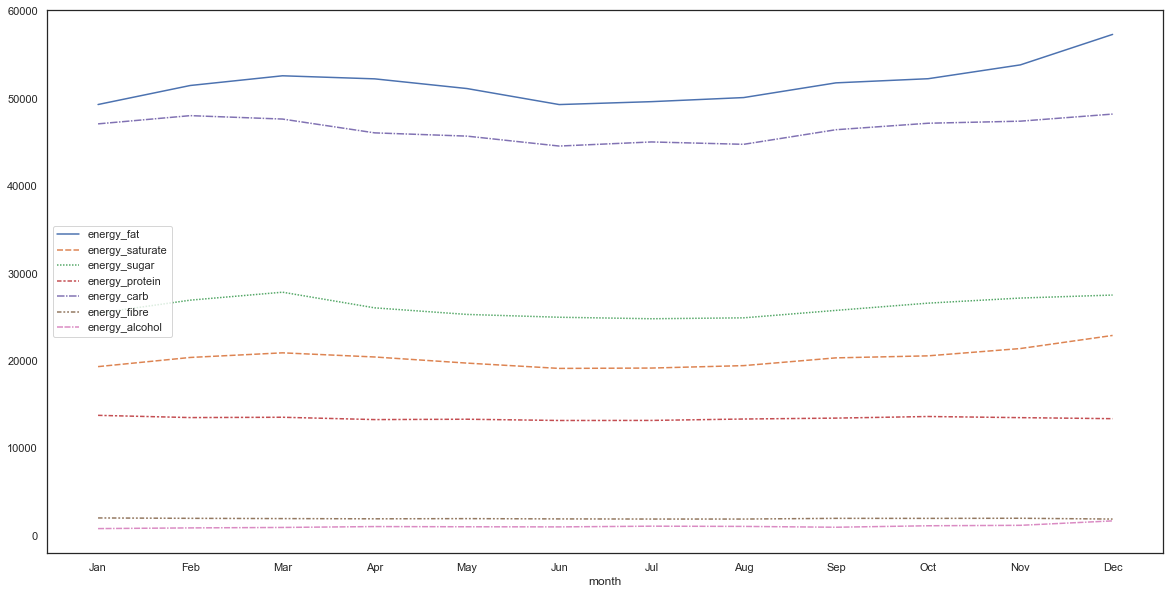

In [479]:
fig, ax = plt.subplots(figsize = (20,10))

g = sns.lineplot(data = osward_months.groupby(by = "month").sum()[nutrients], ax = ax)
plt.show()

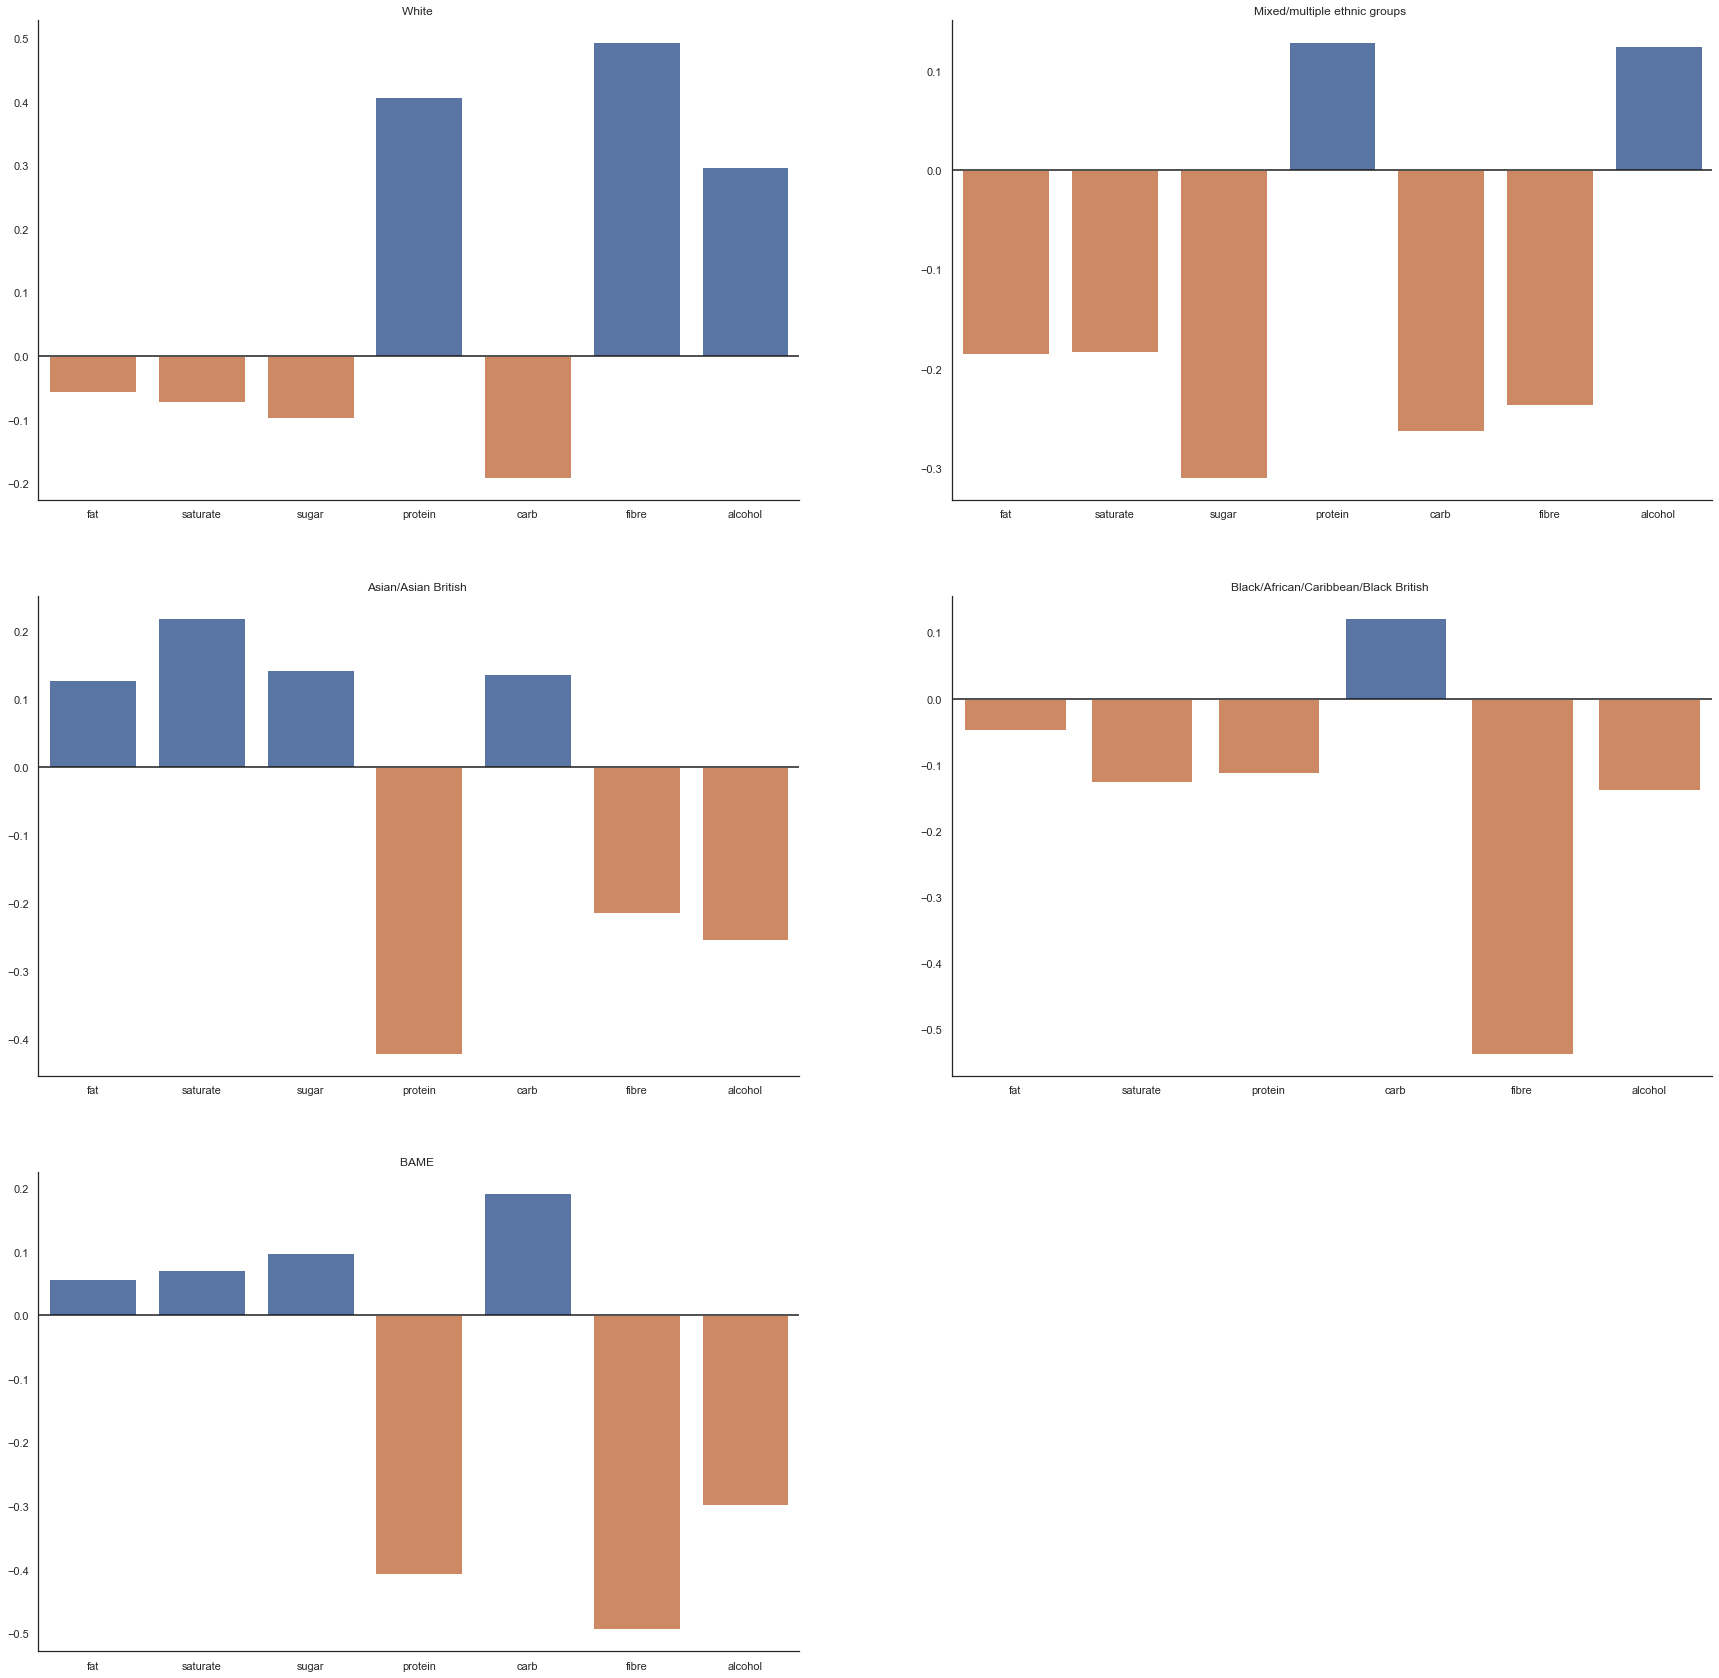

In [480]:
with sns.axes_style("white"): 

    f, axes = plt.subplots(3, 2, figsize=(30, 30))
    axes = axes.flatten()

    for ax, eth in zip(axes,ethnicities):
        correl = [(nutr, stats.spearmanr(a = lsoa_combined_year[eth], b = lsoa_combined_year[nutr]).correlation) for nutr in nutrients if stats.spearmanr(a = lsoa_combined_year[eth], b = lsoa_combined_year[nutr]).pvalue < 0.05]
        colors = [0 if c[1] >= 0 else 1 for c in correl]
        sns.barplot(x= [x[0].split("_")[1] for x in correl], y=[x[1] for x in correl], hue=colors, palette=sns.color_palette(), dodge=False, ax = ax)
        ax.axhline(0, ls='-', c = 'k')
        ax.get_legend().remove()
        ax.set_title(eth.split("perc")[0].replace("_", " "))

    sns.despine(top = True, right = True)
    axes[-1].set_visible(False)

plt.show()

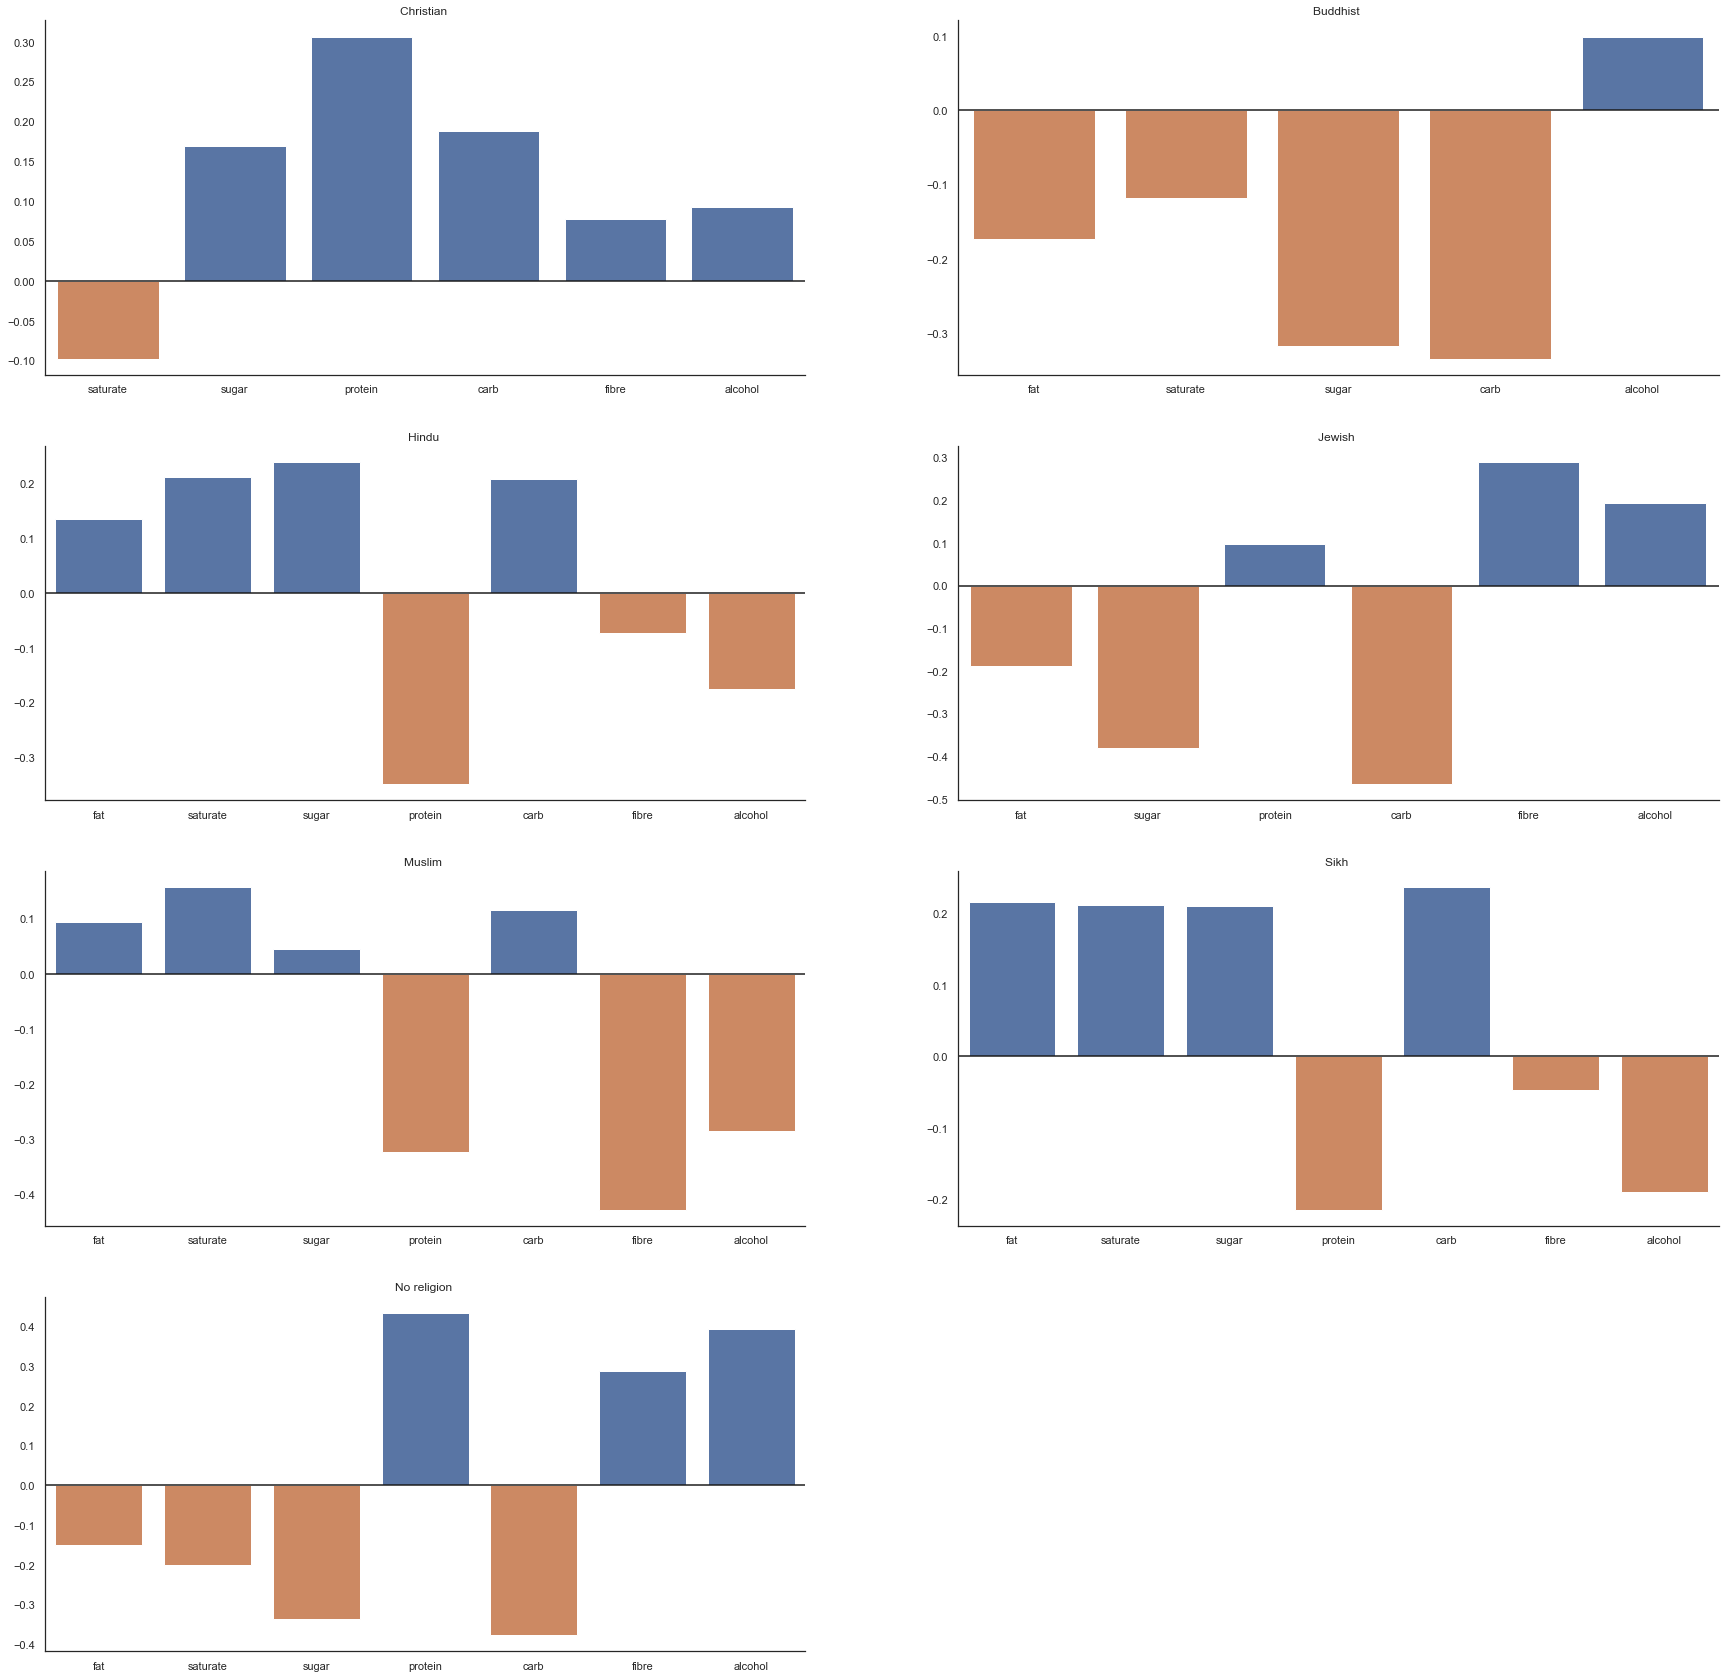

In [481]:
with sns.axes_style("white"): 
    
    f, axes = plt.subplots(4, 2, figsize=(30, 30))
    axes = axes.flatten()

    for ax, faith in zip(axes,religions):
        correl = [(nutr, stats.spearmanr(a = lsoa_combined_year[faith], b = lsoa_combined_year[nutr]).correlation) for nutr in nutrients if stats.spearmanr(a = lsoa_combined_year[faith], b = lsoa_combined_year[nutr]).pvalue < 0.05]
        colors = [0 if c[1] >= 0 else 1 for c in correl]
        sns.barplot(x= [x[0].split("_")[1] for x in correl], y=[x[1] for x in correl], hue=colors, palette=sns.color_palette(), dodge=False, ax = ax)
        ax.axhline(0, ls='-', c = 'k')
        ax.get_legend().remove()
        ax.set_title(faith.split("perc")[0].replace("_", " "))

    sns.despine(top = True, right = True)
    axes[-1].set_visible(False)

plt.show()

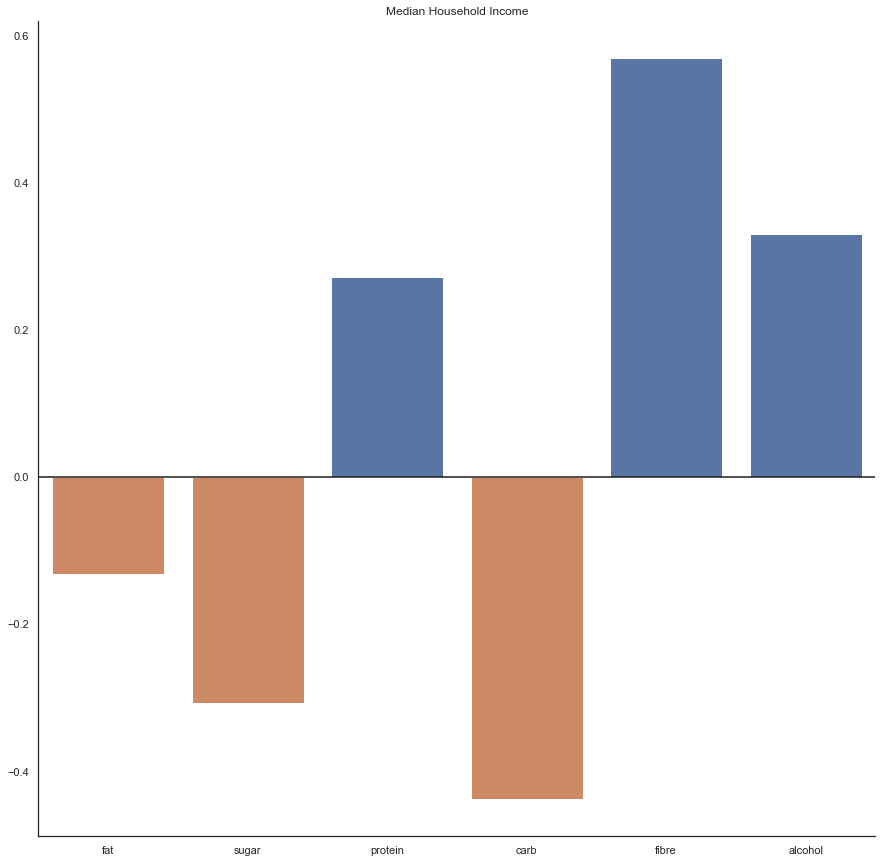

In [482]:
f, (ax) = plt.subplots(1, 1, figsize=(15, 15))
correl = [(nutr, stats.spearmanr(a = lsoa_combined_year["Median_Annual_Household_Income_estimate_pound"], b = lsoa_combined_year[nutr]).correlation) for nutr in nutrients if stats.spearmanr(a = lsoa_combined_year[faith], b = lsoa_combined_year[nutr]).pvalue < 0.05]
colors = [0 if c[1] >= 0 else 1 for c in correl]
sns.barplot(x= [x[0].split("_")[1] for x in correl], y=[x[1] for x in correl], hue=colors, palette=sns.color_palette(), dodge=False, ax = ax)
sns.despine(top = True, right = True)
ax.get_legend().remove()
ax.axhline(0, ls='-', c = 'k')
ax.set_title("Median Household Income")
plt.show()

In [546]:
lsoa_combined_items = lsoa_combined_year[ethnicities + religions + nutrients + ["Median_Annual_Household_Income_estimate_pound"]].copy()
lsoa_combined_items.columns = [x.split("_")[0] for x in  ethnicities] + ['Christian', 'Buddhist','Hindu','Jewish','Muslim','Sikh','No_religion','Other_religion']  + [x.split("_")[1] for x in  nutrients] + ["Median_Income"] 
 
# You could do this probably somewhat smarter 
# Encoding Data into a "Set" Dataset
for col in lsoa_combined_items.columns:
    lower  =  lsoa_combined_items[col].quantile(0.25)
    middle =  lsoa_combined_items[col].quantile(0.5)
    higher =  lsoa_combined_items[col].quantile(0.75)
    lsoa_combined_items[col + "_Low"] = lsoa_combined_items[col].apply(lambda x : x < lower)
    lsoa_combined_items[col + "_Low_to_Middle"] = lsoa_combined_items[col].apply(lambda x : x >= lower and x < middle)
    lsoa_combined_items[col + "_Middle_to_High"] = lsoa_combined_items[col].apply(lambda x :  x < higher and x > middle)
    lsoa_combined_items[col + "_High"] = lsoa_combined_items[col].apply(lambda x : x > higher )
    lsoa_combined_items = lsoa_combined_items.drop(col, axis = 1)
    

# Given the structure of the information, low support is indemic
frequent_itemsets = apriori(lsoa_combined_items, min_support = 0.05, use_colnames = True)

# Use Association Rules as an "explainable" Model
cleaned_names = [x.split("_")[1] for x in nutrients]
cleaned_names = [x + "_High" for x in cleaned_names] + [x + "_Low" for x in cleaned_names] + [x + "Low_to_Middle" for x in cleaned_names]+ [x + "Middle_to_High" for x in cleaned_names]
nutrient_sets = set(cleaned_names)

rules_association = arule(frequent_itemsets, metric = 'confidence', min_threshold = 0.6)
rules_association[rules_association.apply(lambda x : True if x["antecedents"].issubset(nutrient_sets) and not x["consequents"].issubset(nutrient_sets) else False, axis = 1)].sort_values(by = "confidence", ascending = False).head(20)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
7005,"(sugar_Low, carb_Low, fibre_High)",(Median_Income_High),0.068148,0.249947,0.054048,0.793103,3.173092,0.037015,3.625258
2221,"(carb_Low, fibre_High)",(Median_Income_High),0.086520,0.249947,0.068361,0.790123,3.161169,0.046736,3.573784
6079,"(fat_High, saturate_High, protein_Low)",(Asian/Asian_High),0.072634,0.249733,0.053835,0.741176,2.967876,0.035696,2.898759
2204,"(sugar_Low, fibre_High)",(Median_Income_High),0.083102,0.249947,0.060671,0.730077,2.920932,0.039900,2.778769
1381,"(saturate_High, protein_Low)",(Asian/Asian_High),0.091006,0.249733,0.066439,0.730047,2.923310,0.043712,2.779250
2225,"(fibre_Low, alcohol_Low)",(Median_Income_Low),0.074343,0.249947,0.053621,0.721264,2.885674,0.035039,2.690913
6955,"(fat_High, saturate_High, protein_Low)",(No_religion_Low),0.072634,0.248451,0.051912,0.714706,2.876645,0.033866,2.634295
1376,"(fat_High, protein_Low)",(Asian/Asian_High),0.081179,0.249733,0.057253,0.705263,2.824069,0.036980,2.545549
2107,"(saturate_High, protein_Low)",(No_religion_Low),0.091006,0.248451,0.064089,0.704225,2.834462,0.041478,2.540951
9879,"(fat_High, saturate_High, protein_Low)","(White_Low, BAME_High)",0.072634,0.249092,0.050630,0.697059,2.798398,0.032538,2.478725


In [509]:
X = lsoa_combined_year[nutrients]
y = lsoa_combined_year['Median_Annual_Household_Income_estimate_pound']
n_estimators =  [75,100,200,250]
max_features = ["auto", "sqrt"]

    
for x in tqdm(it.product(n_estimators,max_features)): 
    print("\n", x)
    random_forest = RandomForestRegressor(n_estimators = x[0], max_features = x[1])
    print(cross_val_score(estimator = random_forest, X = X, y = y, cv = 20, n_jobs = -1).mean())
    

0it [00:00, ?it/s]


 (75, 'auto')


1it [00:07,  7.99s/it]

0.45731363123289565

 (75, 'sqrt')


2it [00:11,  6.65s/it]

0.4627618316660997

 (100, 'auto')


3it [00:22,  7.84s/it]

0.45873916095827105

 (100, 'sqrt')


4it [00:27,  7.06s/it]

0.4623480467729322

 (200, 'auto')


5it [00:48, 11.35s/it]

0.4616837112996686

 (200, 'sqrt')


6it [00:58, 10.87s/it]

0.4636050873680853

 (250, 'auto')


7it [01:27, 16.32s/it]

0.45943373417423183

 (250, 'sqrt')


8it [01:39, 12.41s/it]

0.4681098886762303


In [547]:
X = lsoa_combined_year[nutrients]
y = lsoa_combined_year['Median_Annual_Household_Income_estimate_pound']
n_estimators = [20,50,100,200,250]
learning_rate = [0.1, 0.05, 0.01]

for x in tqdm(it.product(n_estimators, learning_rate)): 
    print("\n", x)
    lin_regression = LinearRegression()
    ada = AdaBoostRegressor(base_estimator = lin_regression,  n_estimators = x[0], loss = "linear", learning_rate = x[1]) 
  
    print(cross_val_score(estimator = ada, X = X, y = y, cv = 20, n_jobs = -1).mean())
    

1it [00:06,  6.26s/it]

0.35058957835090354


2it [00:06,  4.53s/it]

0.3610931002121213


3it [00:07,  3.35s/it]

0.36553774541100276


4it [00:08,  2.67s/it]

0.3083318214331389


5it [00:09,  2.16s/it]

0.3404836177187203


6it [00:10,  1.80s/it]

0.36491648753047595


7it [00:12,  1.79s/it]

0.27639902621383045


8it [00:13,  1.78s/it]

0.3021119153971883


9it [00:15,  1.76s/it]

0.35966987543019235


10it [00:17,  1.92s/it]

0.2680368451507208


11it [00:21,  2.42s/it]

0.27488776971236983


12it [00:25,  2.78s/it]

0.3482060947122664


13it [00:27,  2.67s/it]

0.2706505310880737


14it [00:31,  3.21s/it]

0.2711925664131137


15it [00:36,  2.46s/it]

0.3382347763694228


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


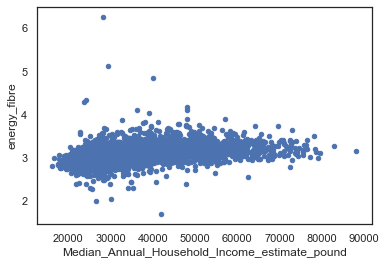

In [488]:
lsoa_combined_year.plot.scatter(x = "Median_Annual_Household_Income_estimate_pound", y = "energy_fibre" )

In [515]:
# Shuffle Split 
x_train, x_test , y_train, y_test = train_test_split(lsoa_combined_year[nutrients], lsoa_combined_year['Median_Annual_Household_Income_estimate_pound'], random_state=0) 
# The Ada Pipeline 
ada_pipeline = pipeline_factory(scaler = StandardScaler(), model = AdaBoostRegressor(base_estimator = LinearRegression()), x_train = x_train, y_train = y_train)

ada_pipeline.score(x_test, y_test)

0.3133644212556176

In [524]:

X = msoa_combined_year[nutrients]
y = msoa_combined_year['Total_Median_Annual_Household_Income_pound_']

n_estimators =  [75,100,200,250]
max_features = ["auto", "sqrt"]

    
for x in tqdm(it.product(n_estimators,max_features)): 
    print("\n", x)
    random_forest = RandomForestRegressor(n_estimators = x[0], max_features = x[1])
    print(cross_val_score(estimator = random_forest, X = X, y = y, cv = 20, n_jobs = -1).mean())
    

0it [00:00, ?it/s]


 (75, 'auto')


1it [00:07,  7.08s/it]

0.557711952253416

 (75, 'sqrt')


2it [00:08,  5.30s/it]

0.5649677324780058

 (100, 'auto')


3it [00:10,  4.51s/it]

0.5593265629803432

 (100, 'sqrt')


4it [00:12,  3.71s/it]

0.5616747761267001

 (200, 'auto')


5it [00:17,  4.12s/it]

0.5621469890675235

 (200, 'sqrt')


6it [00:20,  3.75s/it]

0.5658309117520502

 (250, 'auto')


7it [00:26,  4.32s/it]

0.5612681737781187

 (250, 'sqrt')


8it [00:29,  3.74s/it]

0.562543610523684


In [549]:
X = msoa_combined_year[nutrients]
y = msoa_combined_year['Total_Median_Annual_Household_Income_pound_']
n_estimators = [20,50,100,200,250]
learning_rate = [0.1, 0.05, 0.01]

for x in tqdm(it.product(n_estimators, learning_rate)): 
    print("\n", x)
    lin_regression = LinearRegression()
    ada = AdaBoostRegressor(base_estimator = lin_regression,  n_estimators = x[0], loss = "linear", learning_rate = x[1]) 
  
    print(cross_val_score(estimator = ada, X = X, y = y, cv = 20, n_jobs = -1).mean())
    

0it [00:00, ?it/s]


 (20, 0.1)


1it [00:00,  3.26it/s]

0.4918458582936826

 (20, 0.05)


2it [00:00,  3.35it/s]

0.4949592166669894

 (20, 0.01)


3it [00:00,  3.24it/s]

0.501134609877153

 (50, 0.1)


4it [00:01,  2.37it/s]

0.46167485168900413

 (50, 0.05)


5it [00:02,  2.28it/s]

0.4848030221594152

 (50, 0.01)


6it [00:02,  2.04it/s]

0.5020926200333669

 (100, 0.1)


7it [00:03,  1.82it/s]

0.44688002475413685

 (100, 0.05)


8it [00:04,  1.49it/s]

0.45741427178813227

 (100, 0.01)


9it [00:05,  1.39it/s]

0.5026832636426412

 (200, 0.1)


10it [00:05,  1.41it/s]

0.4468153126201407

 (200, 0.05)


11it [00:07,  1.11it/s]

0.4443836208870547

 (200, 0.01)


12it [00:08,  1.12s/it]

0.49086762568135967

 (250, 0.1)


13it [00:09,  1.02it/s]

0.44909457027642985

 (250, 0.05)


14it [00:10,  1.09s/it]

0.44868535946762583

 (250, 0.01)


15it [00:13,  1.14it/s]

0.4867588310519756


In [545]:
msoa_combined_items = msoa_combined_year[ethnicities + religions + nutrients + ["Total_Median_Annual_Household_Income_pound_"]].copy()
msoa_combined_items.columns = [x.split("_")[0] for x in  ethnicities] + ['Christian', 'Buddhist','Hindu','Jewish','Muslim','Sikh','No_religion','Other_religion']  + [x.split("_")[1] for x in  nutrients] + ["Median_Income"] 
 
# You could do this probably somewhat smarter 
# Encoding Data into a "Set" Dataset
for col in msoa_combined_items.columns:
    lower  =  msoa_combined_items[col].quantile(0.25)
    middle =  msoa_combined_items[col].quantile(0.5)
    higher =  msoa_combined_items[col].quantile(0.75)
    msoa_combined_items[col + "_Low"] = msoa_combined_items[col].apply(lambda x : x < lower)
    msoa_combined_items[col + "_Low_to_Middle"] = msoa_combined_items[col].apply(lambda x : x >= lower and x < middle)
    msoa_combined_items[col + "_Middle_to_High"] = msoa_combined_items[col].apply(lambda x :  x < higher and x > middle)
    msoa_combined_items[col + "_High"] = msoa_combined_items[col].apply(lambda x : x > higher )
    msoa_combined_items = msoa_combined_items.drop(col, axis = 1)
    
# Given the structure of the information, low support is indemic
frequent_itemsets = apriori(msoa_combined_items, min_support = 0.05, use_colnames = True)

# Use Association Rules as an "explainable" Model
cleaned_names = [x.split("_")[1] for x in nutrients]
cleaned_names = [x + "_High" for x in cleaned_names] + [x + "_Low" for x in cleaned_names] + [x + "Low_to_Middle" for x in cleaned_names]+ [x + "Middle_to_High" for x in cleaned_names]
nutrient_sets = set(cleaned_names)

rules_association = arule(frequent_itemsets, metric = 'confidence', min_threshold = 0.6)
rules_association[rules_association.apply(lambda x : True if x["antecedents"].issubset(nutrient_sets) and not x["consequents"].issubset(nutrient_sets) else False, axis = 1)].sort_values(by = "confidence", ascending = False).head(20)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
12320,"(alcohol_High, carb_Low, fibre_High)",(Median_Income_High),0.051688,0.250000,0.050633,0.979592,3.918367,0.037711,36.750000
2899,"(alcohol_High, fibre_High)",(Median_Income_High),0.070675,0.250000,0.063291,0.895522,3.582090,0.045622,7.178571
9445,"(protein_Low, alcohol_Low, saturate_High)",(Asian/Asian_High),0.059072,0.250000,0.051688,0.875000,3.500000,0.036920,6.000000
9459,"(alcohol_Low, carb_High, protein_Low)",(Asian/Asian_High),0.063291,0.250000,0.054852,0.866667,3.466667,0.039030,5.625000
1971,"(fibre_High, alcohol_High)",(BAME_Low),0.070675,0.250000,0.060127,0.850746,3.402985,0.042458,5.025000
6657,"(fibre_High, alcohol_High)","(BAME_Low, White_High)",0.070675,0.250000,0.060127,0.850746,3.402985,0.042458,5.025000
978,"(fibre_High, alcohol_High)",(White_High),0.070675,0.250000,0.060127,0.850746,3.402985,0.042458,5.025000
12203,"(alcohol_Low, carb_High, protein_Low)",(No_religion_Low),0.063291,0.250000,0.053797,0.850000,3.400000,0.037975,5.000000
9424,"(fat_High, alcohol_Low, protein_Low)",(Asian/Asian_High),0.062236,0.250000,0.052743,0.847458,3.389831,0.037184,4.916667
9439,"(protein_Low, carb_High, saturate_High)",(Asian/Asian_High),0.072785,0.250000,0.061181,0.840580,3.362319,0.042985,4.704545


In [554]:
log_model_interaction_variable = smf.ols(formula='BAME_perc ~ energy_fat + energy_saturate + energy_sugar + energy_protein + energy_carb + energy_fibre + energy_alcohol',data=msoa_combined_year)
res = log_model_interaction_variable.fit()

# Print thes summary output provided by the library.
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:              BAME_perc   R-squared:                       0.653
Model:                            OLS   Adj. R-squared:                  0.651
Method:                 Least Squares   F-statistic:                     252.8
Date:                Sun, 22 Nov 2020   Prob (F-statistic):          4.00e-211
Time:                        13:20:52   Log-Likelihood:                -3646.0
No. Observations:                 948   AIC:                             7308.
Df Residuals:                     940   BIC:                             7347.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept         389.9415     14.387     

In [555]:
log_model_interaction_variable = smf.ols(formula='Total_Median_Annual_Household_Income_pound_ ~ energy_fat + energy_saturate + energy_sugar + energy_protein + energy_carb + energy_fibre + energy_alcohol',data=msoa_combined_year)
res = log_model_interaction_variable.fit()

# Print thes summary output provided by the library.
print(res.summary())

                                         OLS Regression Results                                        
Dep. Variable:     Total_Median_Annual_Household_Income_pound_   R-squared:                       0.595
Model:                                                     OLS   Adj. R-squared:                  0.592
Method:                                          Least Squares   F-statistic:                     197.6
Date:                                         Sun, 22 Nov 2020   Prob (F-statistic):          8.59e-180
Time:                                                 13:20:52   Log-Likelihood:                -9737.3
No. Observations:                                          948   AIC:                         1.949e+04
Df Residuals:                                              940   BIC:                         1.953e+04
Df Model:                                                    7                                         
Covariance Type:                                     nonrobust  

In [557]:
for col in msoa_social: 
    print(col)

MSOA Name
Age Structure (2011 Census);All Ages;
Age Structure (2011 Census);0-15;
Age Structure (2011 Census);16-29;
Age Structure (2011 Census);30-44;
Age Structure (2011 Census);45-64;
Age Structure (2011 Census);65+;
Age Structure (2011 Census);Working-age;
Mid-year Estimate totals;All Ages;2002
Mid-year Estimate totals;All Ages;2003
Mid-year Estimate totals;All Ages;2004
Mid-year Estimate totals;All Ages;2005
Mid-year Estimate totals;All Ages;2006
Mid-year Estimate totals;All Ages;2007
Mid-year Estimate totals;All Ages;2008
Mid-year Estimate totals;All Ages;2009
Mid-year Estimate totals;All Ages;2010
Mid-year Estimate totals;All Ages;2011
Mid-year Estimate totals;All Ages;2012
Mid-year Estimates 2012, by age;% 0 to 14;
Mid-year Estimates 2012, by age;% 15-64;
Mid-year Estimates 2012, by age;% 65+;
Mid-year Estimates 2012, by age;0-4;
Mid-year Estimates 2012, by age;5-9;
Mid-year Estimates 2012, by age;10-14;
Mid-year Estimates 2012, by age;15-19;
Mid-year Estimates 2012, by age;20-